In [7]:
import torch
import torch.nn as nn
from torch import Tensor

def conv_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

def conv_1_3(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,3,1,1),
        nn.ReLU()
    )
    return model

def conv_1_5(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU()
    )
    return model

def max_3_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

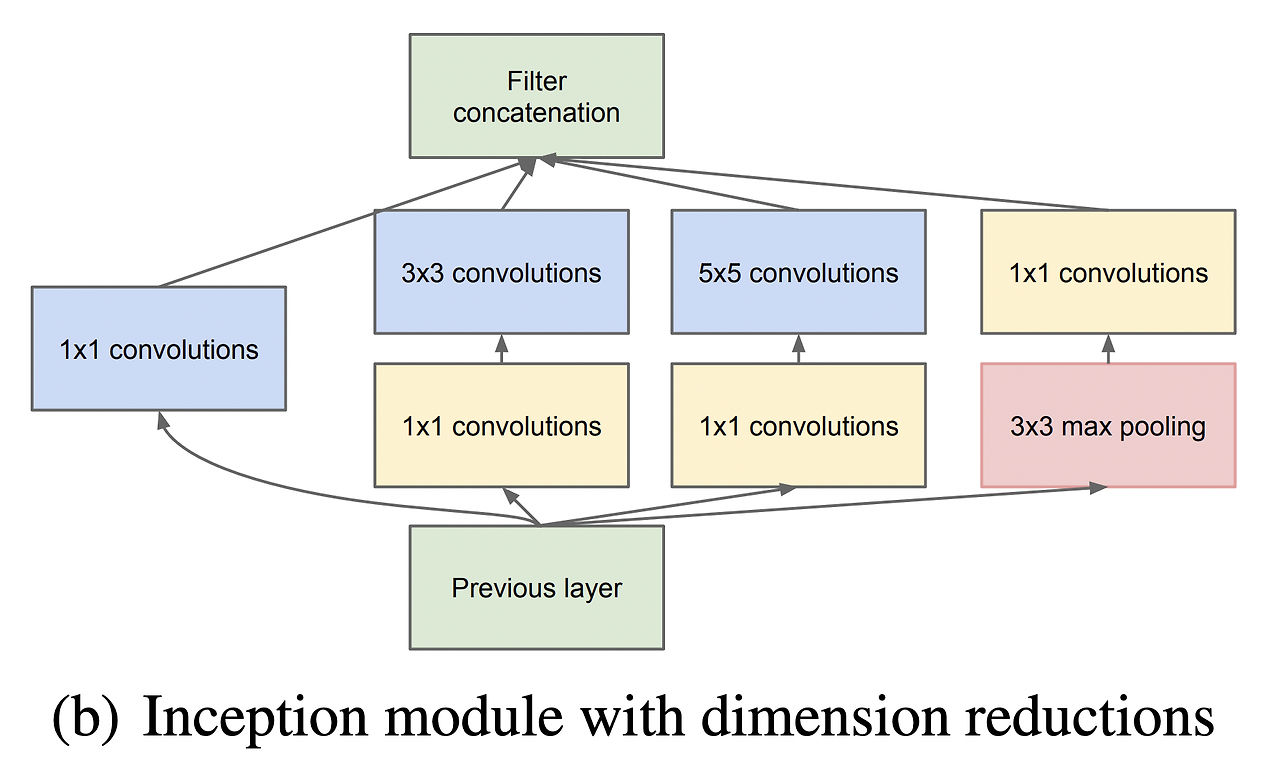

In [8]:
class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output

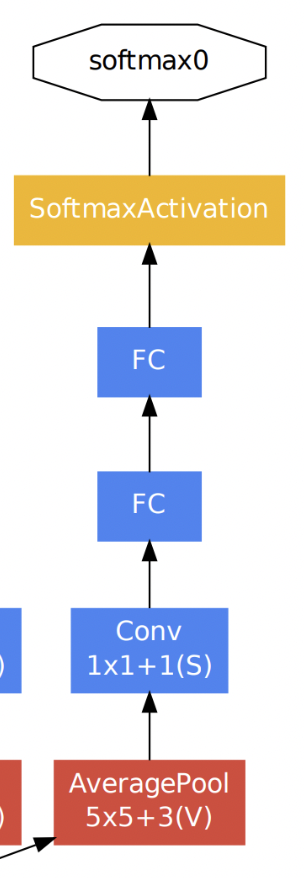

In [9]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes) -> None:
        super(InceptionAux, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = ConvBlock(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.7)
        self.relu = nn.ReLU()

    def forward(self, x: Tensor) -> Tensor:
        x = self.avgpool(x)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

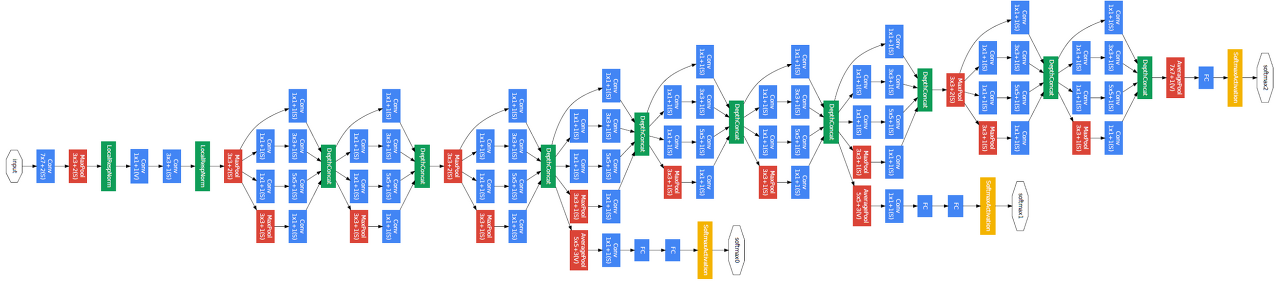

In [10]:
# 구글넷 구현
# base_dim 64
import torch
import torch.nn as nn
from torch import Tensor

def conv_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

def conv_1_3(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,3,1,1),
        nn.ReLU()
    )
    return model

def conv_1_5(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU()
    )
    return model

def max_3_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output
    
class GoogLeNet(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.MaxPool2d(3,2,1),
            nn.LocalResponseNorm(),
            nn.Conv2d(base_dim,base_dim*3,3,1,1),
            nn.LocalResponseNorm(),
            nn.MaxPool2d(3,2,1)
        )
        # indim outdim1 middim3 outdim3 middim5 outdim5 pooldim
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),
            inception_module(base_dim*4,128,128,192,32,96,64),
            nn.MaxPool2d(3,2,1)
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),
            inception_module(512,160,112,224,24,64,64),
            inception_module(512,128,128,256,24,64,64),
            inception_module(512,112,144,288,32,64,64),
            inception_module(528,256,160,320,32,128,128),
            nn.MaxPool2d(3,2,1)
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),
            inception_module(832,384,192,384,48,128,128), 
            nn.AvgPool2d(7,1)
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)
                
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [12]:
import os
import numpy as np

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import argparse

def load_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train = datasets.CIFAR10(root='', train=True, transform=transform, download=True)
    test = datasets.CIFAR10(root='', train=False, transform=transform, download=True)
    train_loader = DataLoader(train, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=args.batch_size, shuffle=True)
    return train_loader, test_loader

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', action='store', type=int, default=100)
    parser.add_argument('--learning_rate', action='store', type=float, default='0.0002')
    parser.add_argument('--n_epochs', action='store', type=int, default=100)
    parser.add_argument('--plot', action='store', type=bool, default=True)
    args = parser.parse_args()

    np.random.seed(1)
    seed = torch.manual_seed(1)

    # load dataset
    train_loader, test_loader = load_dataset()
    
    losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GoogLeNet(num_classes=10).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    for epoch in range(args.n_epochs):
        model.train()
        train_loss = 0
        correct, count = 0, 0
        for batch_idx, (images, labels) in enumerate(train_loader, start=1):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(output, 1)
            count += labels.size(0)
            correct += torch.sum(preds == labels)

            if batch_idx % 100 == 0:
                print(f"[*] Epoch: {epoch} \tStep: {batch_idx}/{len(train_loader)}\tTrain accuracy: {round((correct/count), 4)} \tTrain Loss: {round((train_loss/count)*100, 4)}")

        # valid
        model.eval()
        correct, count = 0, 0
        valid_loss = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(test_loader, start=1):
                images, labels = images.to(device), labels.to(device)
                output = model.forward(images)
                loss = criterion(output, labels)
                valid_loss += loss.item()
                _, preds = torch.max(output, 1)
                count += labels.size(0)
                correct += preds.eq(labels).sum().item() # torch.sum(preds == labels)
                if batch_idx % 100 == 0:
                    print (f"[*] Step: {batch_idx}/{len(test_loader)}\tValid accuracy: {round((correct/count), 4)} \tValid Loss: {round((valid_loss/count)*100, 4)}")

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--learning_rate LEARNING_RATE]
                             [--n_epochs N_EPOCHS] [--plot PLOT]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\MoonDongWon\AppData\Roaming\jupyter\runtime\kernel-v2-15896RKAbmRz85A0A.json


SystemExit: 2

c:\Users\MoonDongWon\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
